# PCA Plots

## General settings and loading files

In [ ]:
% load_ext autoreload
% autoreload 2

In [ ]:
%%time

% matplotlib inline
% load_ext autoreload
% autoreload 2

% run general_settings.py
# ^ Takes ~20s to run if it finds the dumpfiles
# ^ WARNING: It will hog ~2.02 Gb RAM

% run datasets_settings.py

! echo; wc -l /home/juan/tesina/dataset_dumps/*.samples | grep -v total

## Create the datasets
Lists of sample IDs of chosen populations to later filter 1000 Genomes data.

## PCA plots

In [ ]:
# %%time

# == WARNING ==
# This cell will take ~4m to execute

from plotters.pca_plotter import PCAPlotter

pca_plotter = PCAPlotter()
components_to_compare = [("PC1", "PC2")]

def make_filename(dataset_label, panel_labels, components_to_compare):
    return "{}__{}__PCx{}".format(dataset_label,
                                "_".join(panel_labels),
                             len(components_to_compare) * 2)

for dataset_label, sample_ids in dataset_samples.items():
    
    
    fig_title = "Dataset: {}".format(dataset_names[dataset_label])

    # GAL Panles
    dataset_genotypes = df_1000G_genotypes.loc[sample_ids, :]
    filename = make_filename(dataset_label, panel_labels, components_to_compare)
    populations_to_plot = dataset_populations[dataset_label]  # Order to the plot!
    pca_plotter.plot(fig_title, panel_rsIDs, dataset_genotypes, df_1000G_samples,
                     components_to_compare, panel_names, filename,
                     populations_to_plot)
    
    # Control Panels
    dataset_genotypes = control_genotypes.loc[sample_ids, :]
    filename = make_filename(dataset_label, control_labels, components_to_compare)
    populations_to_plot = dataset_populations[dataset_label]  # Order to the plot!
    pca_plotter.plot(fig_title, control_rsIDs, dataset_genotypes, df_1000G_samples,
                     components_to_compare, control_names, filename,
                     populations_to_plot)
    
    # Control Panels - Extra components
    only_big_cp = {"CPx100": control_rsIDs["CPx100"]}
    more_components_to_compare = [("PC3", "PC4"), ("PC5", "PC6"),
                                  ("PC7", "PC8")]
    dataset_genotypes = control_genotypes.loc[sample_ids, :]
    populations_to_plot = dataset_populations[dataset_label]  # Order to the plot!
    filename = make_filename(dataset_label, ["100"], more_components_to_compare)
    pca_plotter.plot(fig_title, only_big_cp, dataset_genotypes, df_1000G_samples,
                     more_components_to_compare, control_names, filename,
                     populations_to_plot)

# Testing refactoring of PCA classes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPx1 · 438 SNPs Latinos


ValueError: level name population is not the name of the index

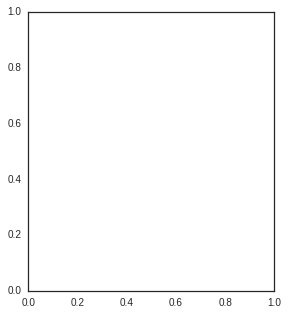

In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from components.panel import Panel
from components.dataset import Dataset


import matplotlib.pyplot as plt
import seaborn as sns

from pca.pca_generator import PCAGenerator
from pca.pca_plotter import PCAPlotter


sns.set_context("notebook")
sns.set_style("white")

pca_generator = PCAGenerator()
pca_plotter = PCAPlotter()

for dataset in Dataset.all_datasets():

    for panel in Panel.all_panels():

        print(panel.name, dataset.name)
        genotypes = panel.genotypes_1000G(dataset=dataset)
        pca_df, explained_var = pca_generator.principal_components(genotypes)
        pca_plotter.plot(pca_df, explained_var,
                         [("PC1", "PC2"), ("PC3", "PC4")],
                         "{}\n{}".format(dataset.name, panel.name),
                         suffix="")
        plt.show()

In [1]:
%%time

# This cell takes ~27s

%load_ext autoreload
%autoreload 2

from datasets.dataset import Dataset
from panels.panel_creator import PanelCreator

panel_creator = PanelCreator()
panels = panel_creator.read_AIMs_panels()
control_panels = panel_creator.read_control_panels()  # 1.3 Gb

CPU times: user 24.5 s, sys: 2.51 s, total: 27 s
Wall time: 26.4 s


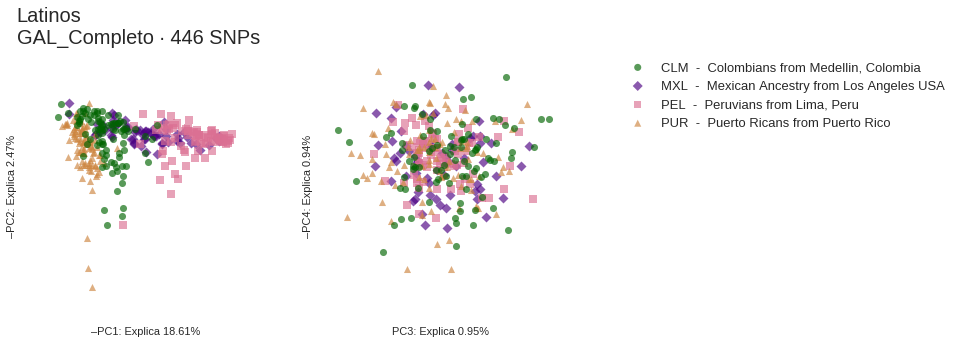

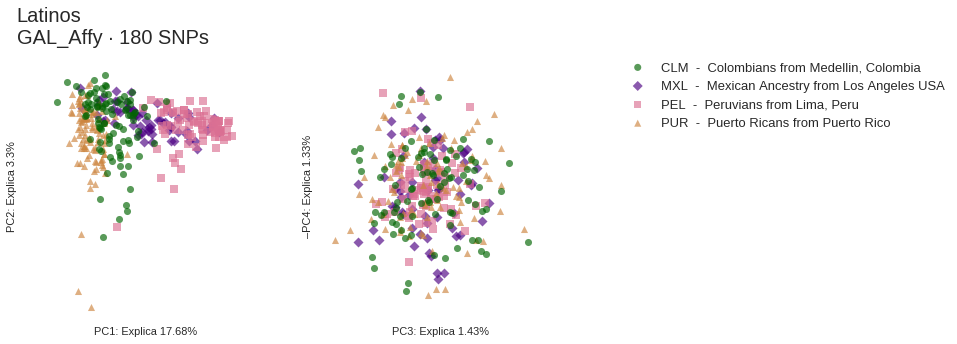

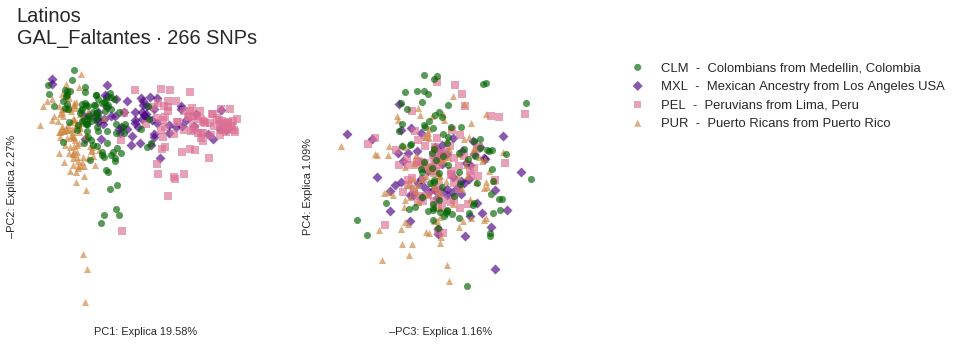

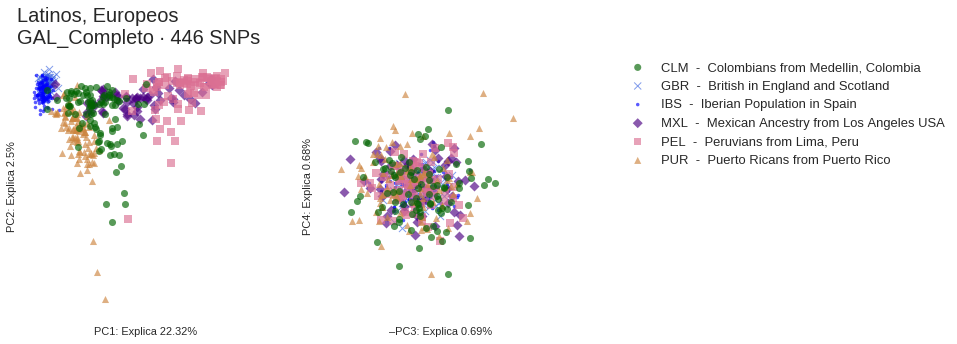

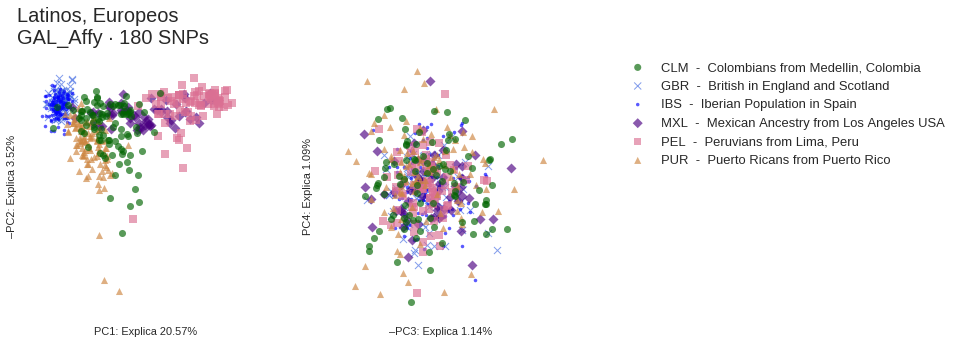

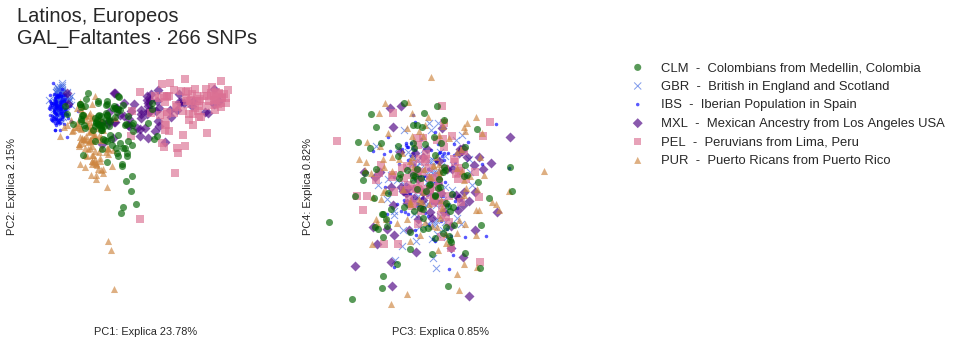

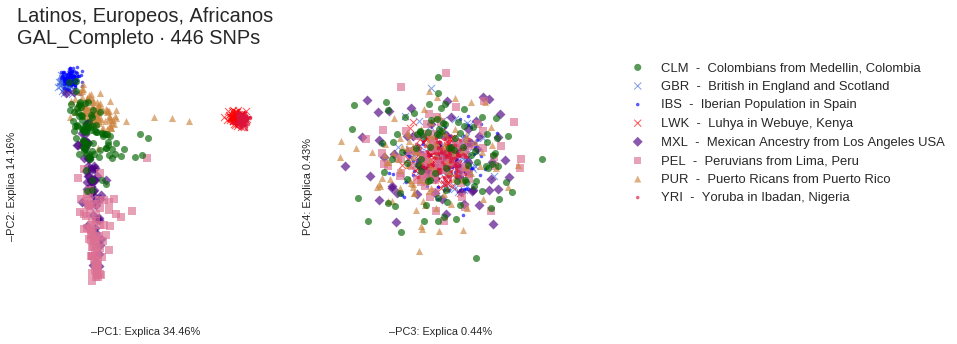

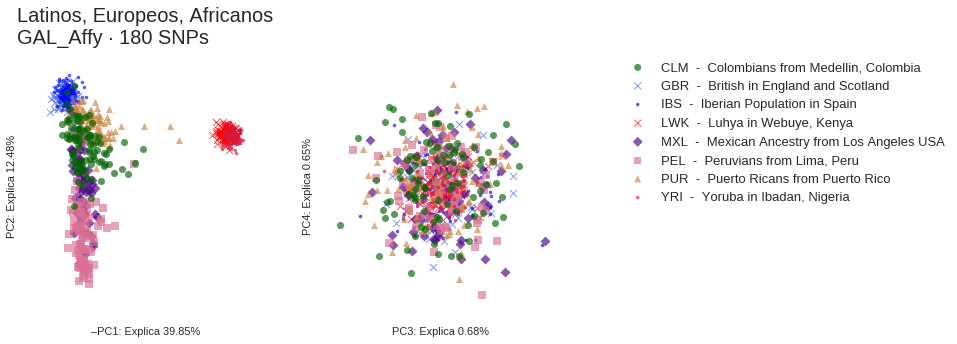

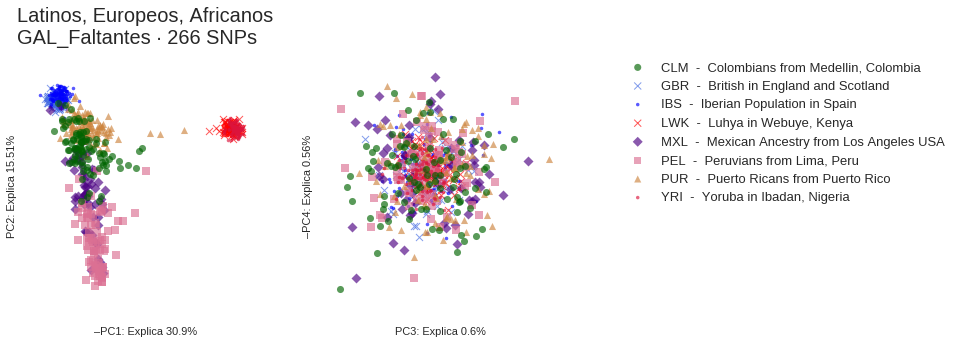

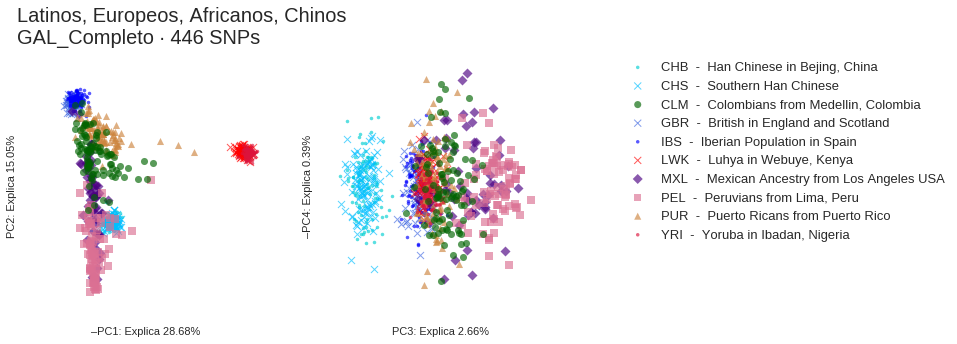

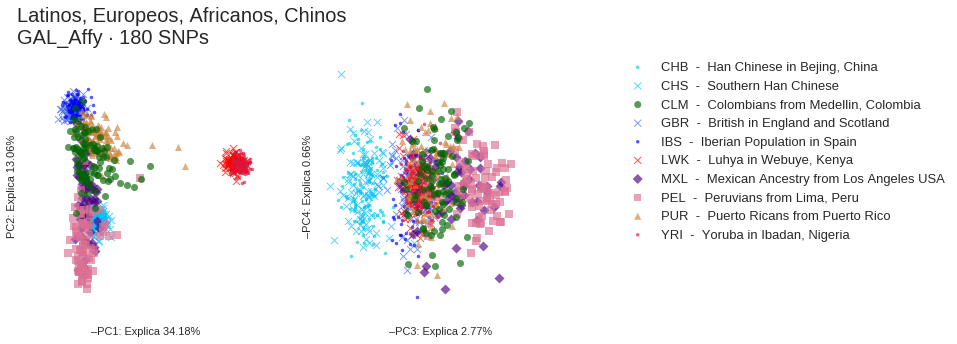

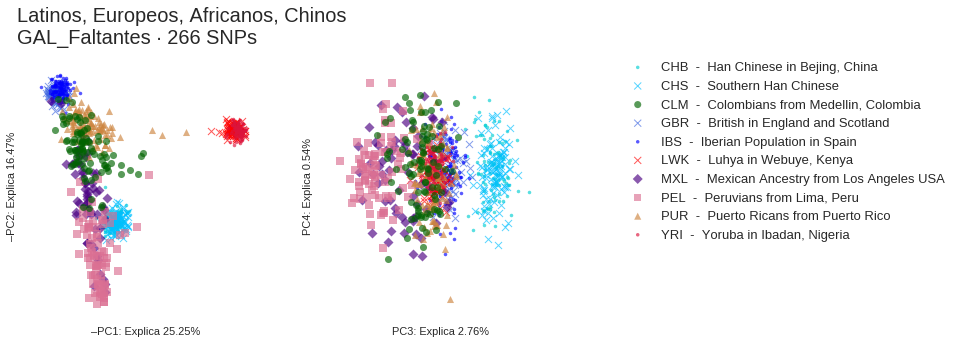

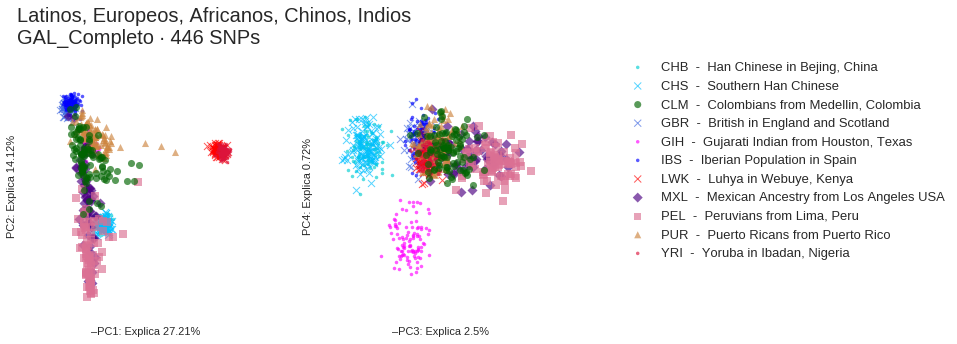

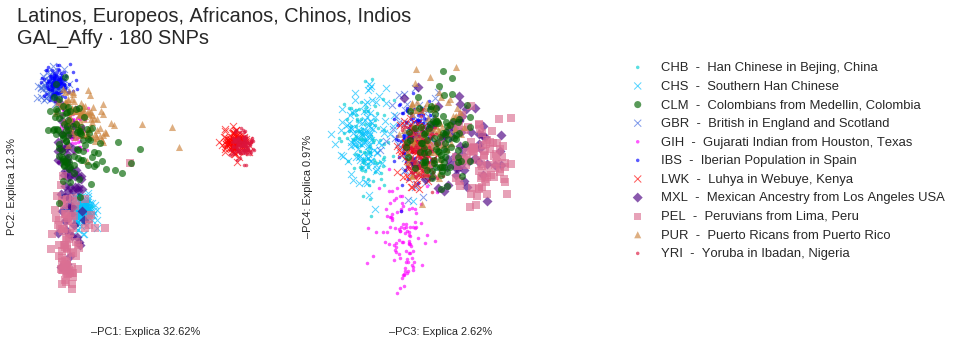

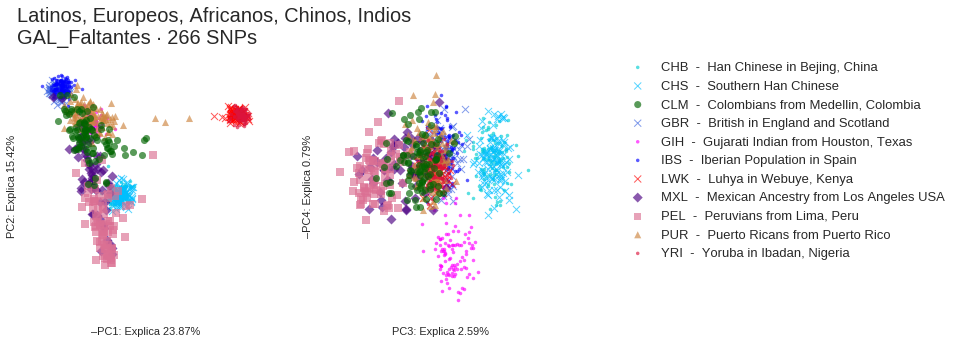

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from panels.panel import Panel
from datasets.dataset import Dataset
from pca.pca_generator import PCAGenerator
from pca.pca_plotter import PCAPlotter


sns.set_context("notebook")
sns.set_style("white")

pca_generator = PCAGenerator()
pca_plotter = PCAPlotter()

for dataset in Dataset.all_datasets():

    for panel in panels:

        genotypes = panel.genotypes(dataset=dataset)
        pca_df, explained_var = pca_generator.principal_components(genotypes)
        pca_plotter.plot(pca_df, explained_var,
                         [("PC1", "PC2"), ("PC3", "PC4")],
                         "{}\n{}".format(dataset.name, panel.name),
                         suffix="")
        plt.show()
